# **Import Statements**

In [5]:
import sys
root = "C:\\Users\\saman\\OneDrive\\Documents\\GitHub\\Eyelid-Modeling\\" #laptop path
#root = "C:\\Users\\Samantha\\Documents\\GitHub\\Eyelid-Modeling\\" #desktop path
sys.path.append(root)

from utils.experiment_manager import Experiment
from models.EMG_RNN_CNN import EMG_RNN_CNN_Wrapper
from utils.data_management import Mat2TVT

import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

# **Data Reorganization** <br>


In [2]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = root + 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)

# **Run Experiments**

In [ ]:
params = {
    't_win': np.arange(10,51,1, dtype = float),
    't_stride': np.arange(10, 51, 1, dtype = float),
    't_lookahead': np.arange(50, 101, 1, dtype = float),
    'win_mode': ['win_fft', 'win_rect'],
    'p_transform': np.linspace(0, 1, 100, dtype = float),
    'sigma': np.linspace(0, 5, 100, dtype = float),
    'p_mask': np.linspace(0, 0.5, 100, dtype = float),
    'batch_size': [4, 8, 16, 32, 64, 128],
    'learning_rate': np.linspace(1e-3, 1e-8, 500, dtype = float),
    'dropout': np.linspace(0, 1, 100, dtype = float),
    'RNN_hdim': [4, 8, 16, 32, 64, 128],
    'RNN_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'CNN_kernel': [3, 5]
}

experiment = Experiment()
model = EMG_RNN_CNN_Wrapper()
best_params = experiment(params, TVT_dict, model, n_trials = 250, epochs = 100, patience = 25, gcollect = False) 

print("Best Params:\n_________________________________________________________________________________________________________")
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

with open("best_params.pickle", "wb") as file:
    pickle.dump(best_params, file)

[I 2025-03-14 17:10:22,498] A new study created in memory with name: no-name-20cfc36b-2d9d-4049-9688-b3714436023f


Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 3930.0%, Avg Marker Error: 164.0%, Avg loss: 5636.136719 

Epoch 2
-------------------------------


[I 2025-03-14 17:10:25,244] Trial 0 finished with value: 5288.7666015625 and parameters: {'t_win': np.float64(44.0), 't_stride': np.float64(49.0), 't_lookahead': np.float64(63.0), 'win_mode': 'win_rect', 'p_transform': np.float64(0.888888888888889), 'sigma': np.float64(2.9797979797979797), 'p_mask': np.float64(0.25252525252525254), 'batch_size': 64, 'learning_rate': np.float64(0.00016032903807615222), 'dropout': np.float64(0.22222222222222224), 'RNN_hdim': 32, 'RNN_depth': 7, 'CNN_kernel': 5}. Best is trial 0 with value: 5288.7666015625.


Validation Error: 
 Max Marker Error: 3359.4%, Avg Marker Error: 153.4%, Avg loss: 5288.766602 

Done!
Best Params:
_________________________________________________________________________________________________________
    t_win: 44.0
    t_stride: 49.0
    t_lookahead: 63.0
    win_mode: win_rect
    p_transform: 0.888888888888889
    sigma: 2.9797979797979797
    p_mask: 0.25252525252525254
    batch_size: 64
    learning_rate: 0.00016032903807615222
    dropout: 0.22222222222222224
    RNN_hdim: 32
    RNN_depth: 7
    CNN_kernel: 5


# **Training Model with Best Params**

In [ ]:
'''
Loading Stuff, to be used only if kernel crashes and need to train model after getting best params

model = EMG_RNN_CNN_Wrapper()
experiment = Experiment()
with open("best_params.pickle", "rb") as file:
    best_params = pickle.load(file)
'''

metrics = experiment.run_experiment(best_params, TVT_dict, model, epochs = 1000, patience = 25)

'''
Saving Model, Training Metrics, and Best Params
'''
with open("training_metrics.pickle", "wb") as file:
    pickle.dump(metrics, file)

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 15370.9%, Avg Marker Error: 170.4%, Avg loss: 5765.391113 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 13454.8%, Avg Marker Error: 161.6%, Avg loss: 5413.292480 

Done!


# **Plotting Loss Metrics**

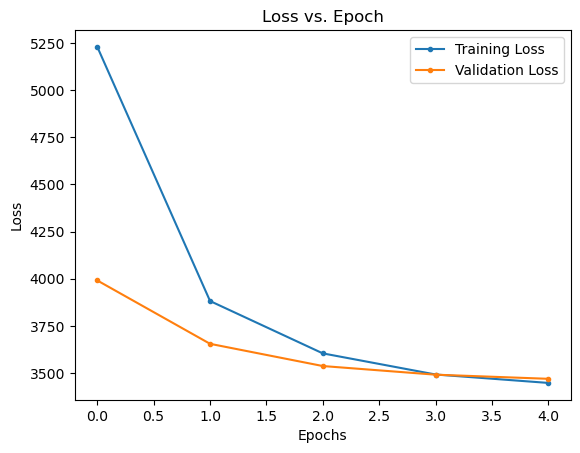

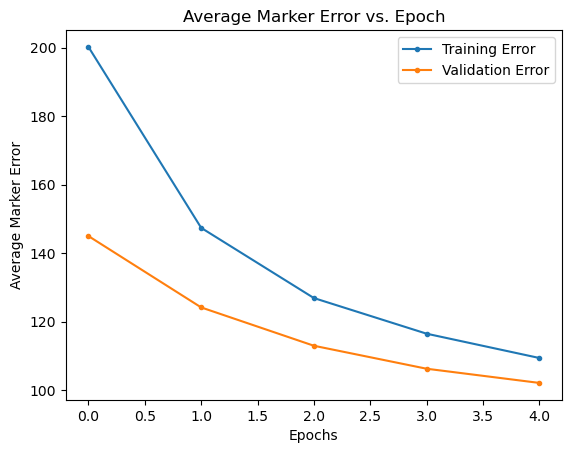

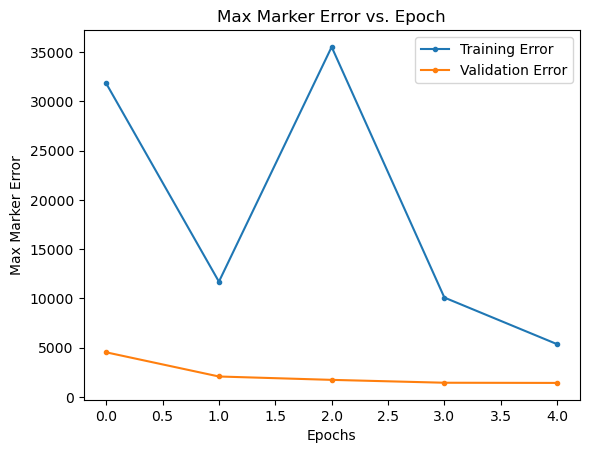

In [ ]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()